In [ ]:
!pip install onnx
!pip install onnxruntime

In [ ]:
import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import torch
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from onnxruntime.quantization import quantize_static, QuantFormat, QuantType

#load data

In [ ]:
# Unzip dataset in Google Colab

zip_file_path = "/content/test.zip"
extract_dir = "/content/"

os.makedirs(extract_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if not file_info.filename.startswith('__MACOSX/'):
                arcname = file_info.filename
                if arcname.startswith('cats-v-non-cats/'):
                    arcname = arcname[len('cats-v-non-cats/'):]

                if arcname:
                    file_info.filename = arcname
                    zip_ref.extract(file_info, extract_dir)

    macosx_folder = os.path.join("/content/", '__MACOSX')
    if os.path.exists(macosx_folder):
        shutil.rmtree(macosx_folder)

except Exception as e:
    print(f"An error occurred during unzipping: {e}")

File extracted to: /content/


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = ImageFolder(root="./test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# evaluate

In [ ]:
def evaluate_onnx_model(onnx_model_path, test_loader):
    session = ort.InferenceSession(onnx_model_path)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name

    correct_predictions = 0
    total_samples = 0

    class_names = {1: 'non-cat', 0: 'cat'}

    for i, (inputs, labels) in enumerate(test_loader):
        inputs_np = inputs.cpu().numpy()

        outputs_np = session.run([output_name], {input_name: inputs_np})[0]

        probabilities = 1 / (1 + np.exp(-outputs_np)) # Sigmoid function
        predicted_classes = (probabilities > 0.5).squeeze()

        total_samples += labels.size(0)
        correct_predictions += (predicted_classes == labels.cpu().numpy()).sum().item()

    accuracy = correct_predictions / total_samples
    return accuracy

# onnx

In [ ]:
input_onnx_path = "80percentPruned.onnx"
output_quantized_onnx_path = "80percentPrunedQuantized.onnx"

In [ ]:
class DataReader(ort.quantization.CalibrationDataReader):
    def __init__(self, dataloader, onnx_model_path):
        self.dataloader = dataloader
        session_temp = ort.InferenceSession(onnx_model_path)
        self.input_name = session_temp.get_inputs()[0].name

        self.enum_data_dicts = iter([{self.input_name: batch[0].numpy()} for batch in dataloader])

    def get_next(self):
        try:
            data = next(self.enum_data_dicts)
            return data
        except StopIteration:
            return None

calibration_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
calibration_reader = DataReader(calibration_dataloader, input_onnx_path)

print("Applying static quantization...")
quantize_static(
    input_onnx_path,
    output_quantized_onnx_path,
    calibration_data_reader=calibration_reader,
    quant_format=QuantFormat.QOperator,
    per_channel=False,
    weight_type=QuantType.QInt8,
    activation_type=QuantType.QInt8
)

Applying static quantization...


In [ ]:
pruned_model = onnx.load(input_onnx_path)

total_weights_size_bytes_before = 0
total_zero_weights_size_bytes_before = 0
total_non_zero_weights_size_bytes_before = 0
total_elements_before = 0
total_zero_elements_before = 0

for initializer in pruned_model.graph.initializer:
    if initializer.data_type == onnx.TensorProto.FLOAT:
        weights_array = onnx.numpy_helper.to_array(initializer)

        num_elements = weights_array.size
        num_zero_elements = np.count_nonzero(weights_array == 0)

        total_elements_before += num_elements
        total_zero_elements_before += num_zero_elements

        element_size_bytes = 4 # float32

        current_weight_size_bytes = num_elements * element_size_bytes
        current_zero_weight_size_bytes = num_zero_elements * element_size_bytes
        current_non_zero_weight_size_bytes = (num_elements - num_zero_elements) * element_size_bytes

        total_weights_size_bytes_before += current_weight_size_bytes
        total_zero_weights_size_bytes_before += current_zero_weight_size_bytes
        total_non_zero_weights_size_bytes_before += current_non_zero_weight_size_bytes

if total_elements_before > 0:
    sparsity_percentage_before = (total_zero_elements_before / total_elements_before) * 100
else:
    sparsity_percentage_before = 0

print(f"Analysis of '{input_onnx_path}' (Before Quantization):")
print(f"Total elements (weights): {total_elements_before}")
print(f"Total zero elements: {total_zero_elements_before}")
print(f"Sparsity percentage (elements that are zero): {sparsity_percentage_before:.2f}%")
print(f"Estimated total weights storage (dense): {total_weights_size_bytes_before / 1024:.2f} KB")
print(f"Estimated non-zero weights storage: {total_non_zero_weights_size_bytes_before / 1024:.2f} KB")
print(f"Estimated zero weights storage: {total_zero_weights_size_bytes_before / 1024:.2f} KB")
print(f"Actual ONNX file size: {os.path.getsize(input_onnx_path) / 1024:.2f} KB\n")


pruned_quantized_model = onnx.load(output_quantized_onnx_path)

total_weights_size_bytes = 0
total_zero_weights_size_bytes = 0
total_non_zero_weights_size_bytes = 0
total_elements = 0
total_zero_elements = 0

for initializer in pruned_quantized_model.graph.initializer:
    if initializer.data_type in [onnx.TensorProto.FLOAT, onnx.TensorProto.INT8, onnx.TensorProto.UINT8]:
        weights_array = onnx.numpy_helper.to_array(initializer)

        num_elements = weights_array.size
        num_zero_elements = np.count_nonzero(weights_array == 0)

        total_elements += num_elements
        total_zero_elements += num_zero_elements

        if initializer.data_type == onnx.TensorProto.FLOAT:
            element_size_bytes = 4
        elif initializer.data_type in [onnx.TensorProto.INT8, onnx.TensorProto.UINT8]:
            element_size_bytes = 1 # 1 byte for Int8/UInt8
        else:
            element_size_bytes = 4 # Default to float size if unknown or other types

        current_weight_size_bytes = num_elements * element_size_bytes
        current_zero_weight_size_bytes = num_zero_elements * element_size_bytes
        current_non_zero_weight_size_bytes = (num_elements - num_zero_elements) * element_size_bytes

        total_weights_size_bytes += current_weight_size_bytes
        total_zero_weights_size_bytes += current_zero_weight_size_bytes
        total_non_zero_weights_size_bytes += current_non_zero_weight_size_bytes

if total_elements > 0:
    sparsity_percentage = (total_zero_elements / total_elements) * 100
else:
    sparsity_percentage = 0

print(f"Analysis of '{output_quantized_onnx_path}' (After Quantization):")
print(f"Total elements (weights): {total_elements}")
print(f"Total zero elements: {total_zero_elements}")
print(f"Sparsity percentage (elements that are zero): {sparsity_percentage:.2f}%")
print(f"Estimated total weights storage (dense): {total_weights_size_bytes / 1024:.2f} KB")
print(f"Estimated non-zero weights storage: {total_non_zero_weights_size_bytes / 1024:.2f} KB")
print(f"Estimated zero weights storage: {total_zero_weights_size_bytes / 1024:.2f} KB")
print(f"Actual ONNX file size: {os.path.getsize(output_quantized_onnx_path) / 1024:.2f} KB")

Analysis of '80percentPruned.onnx' (Before Quantization):
Total elements (weights): 95845
Total zero elements: 0
Sparsity percentage (elements that are zero): 0.00%
Estimated total weights storage (dense): 374.39 KB
Estimated non-zero weights storage: 374.39 KB
Estimated zero weights storage: 0.00 KB
Actual ONNX file size: 379.44 KB

Analysis of '80percentPrunedQuantized.onnx' (After Quantization):
Total elements (weights): 94700
Total zero elements: 2557
Sparsity percentage (elements that are zero): 2.70%
Estimated total weights storage (dense): 105.52 KB
Estimated non-zero weights storage: 103.02 KB
Estimated zero weights storage: 2.50 KB
Actual ONNX file size: 123.27 KB


In [ ]:
pruned_onnx_accuracy = evaluate_onnx_model(input_onnx_path, test_loader)
pruned_model_kb = os.path.getsize(input_onnx_path) / 1024
pruned_quantized_onnx_accuracy = evaluate_onnx_model(output_quantized_onnx_path, test_loader)
pruned_quantized_model_kb = os.path.getsize(output_quantized_onnx_path) / 1024

metrics = {
    "Model": ["Pruned Model", "Pruned Quantized Model"],
    "Accuracy": [pruned_onnx_accuracy, pruned_quantized_onnx_accuracy],
    "Size": [pruned_model_kb, pruned_quantized_model_kb]
}

print(f"Pruned Model Accuracy: {metrics['Accuracy'][0]:.4f}")
print(f"Pruned Model Size: {metrics['Size'][0]:.2f} KB")
print(f"Pruned Quantized Model Accuracy: {metrics['Accuracy'][1]:.4f}")
print(f"Pruned Quantized Model Size: {metrics['Size'][1]:.2f} KB")


Pruned ONNX Model Accuracy: 0.8081
Pruned ONNX Model Size: 379.44 KB
Static Quantized ONNX Model Accuracy: 0.7566
Static Quantized ONNX Model Size: 123.27 KB


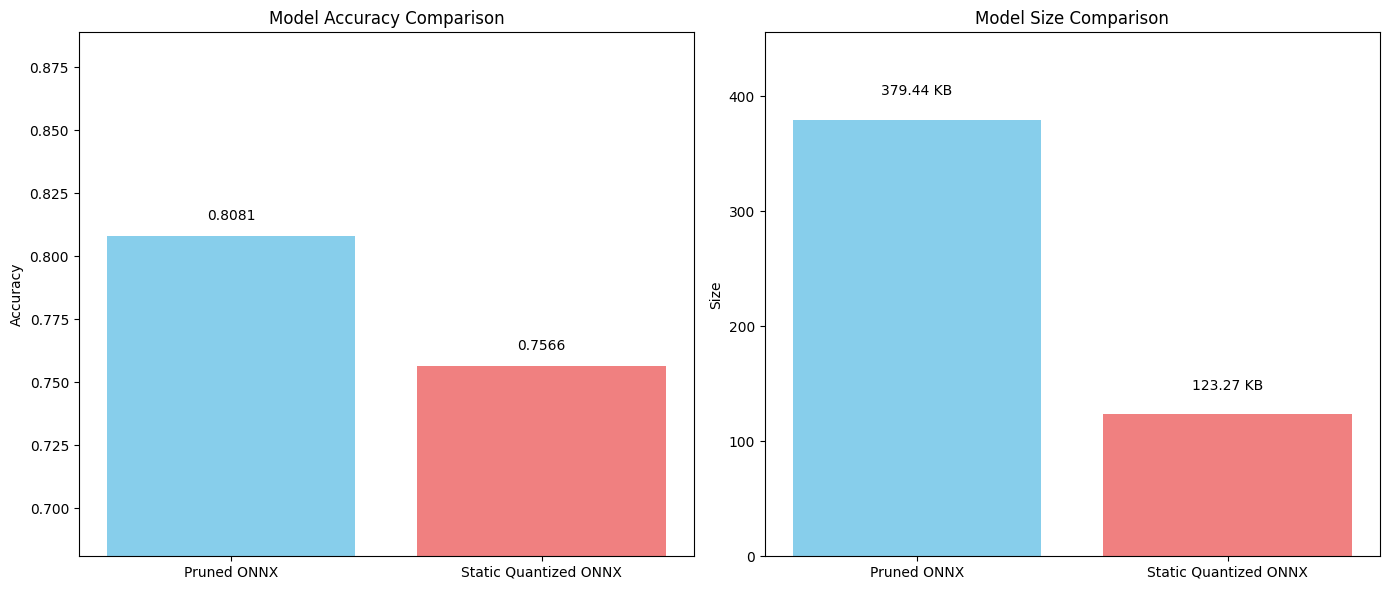

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

models = metrics["Model"]
accuracy_values = metrics["Accuracy"]
size_values = metrics["Size"]

ax[0].bar(models, accuracy_values, color=['skyblue', 'lightcoral'])
ax[0].set_title('Model Accuracy Comparison')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(min(accuracy_values) * 0.9, max(accuracy_values) * 1.1) # Adjust y-axis limit for better visualization
for i, acc in enumerate(accuracy_values):
    ax[0].text(i, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom')

pruned_size_kb = size_values[0]
quantized_size_kb = size_values[1]

ax[1].bar(models, [pruned_size_kb, quantized_size_kb], color=['skyblue', 'lightcoral'])
ax[1].set_title('Model Size Comparison')
ax[1].set_ylabel('Size')
ax[1].set_ylim(0, max(pruned_size_kb, quantized_size_kb) * 1.2)

ax[1].text(0, pruned_size_kb + (max(pruned_size_kb, quantized_size_kb) * 0.05), f'{pruned_size_kb:.2f} KB', ha='center', va='bottom')
ax[1].text(1, quantized_size_kb + (max(pruned_size_kb, quantized_size_kb) * 0.05), f'{quantized_size_kb:.2f} KB', ha='center', va='bottom')

plt.tight_layout()
plt.show()